In [28]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy.stats as st
import random

In [4]:
cur_dir = os.path.dirname('__file__')

train = pd.read_csv(os.path.join(cur_dir, "data", "train.csv"))
test = pd.read_csv(os.path.join(cur_dir, "data", "test.csv"))

In [5]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [6]:

def get_random_subset(df, n):
    sub = random.sample(xrange(len(df)), n)
    return df.iloc[sub]


def preprocess(df):
    
    res = df.copy()
    res.drop(df.index[660485], inplace=True)
    datetimes = res.Dates.apply(get_datetime)
    res['Hour'] = datetimes.apply(lambda dt: dt.hour)
    res['Month'] = datetimes.apply(lambda dt: dt.month)
    res['Hour_Minutes'] = datetimes.apply(lambda dt: dt.hour + dt.minute / 60.0)
    res['Minutes_Since_03'] = datetimes.apply(lambda dt: (dt-datetime(2003, 1, 1)).total_seconds() / 60)
    res['Minutes_Since_New_Year'] = datetimes.apply(lambda dt: (dt-datetime(dt.year, 1, 1)).total_seconds() / 60)
    return res

def hour_min(s):
    dt = get_datetime(s)
    return dt.hour + dt.minute / 60.0

def get_datetime(s):
    dt = datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
    return dt

def get_random_subset(df, n):
    sub = random.sample(xrange(len(df)), n)
    return df.iloc[sub]

In [7]:
train = preprocess(train)

/home/brenna/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/home/brenna/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


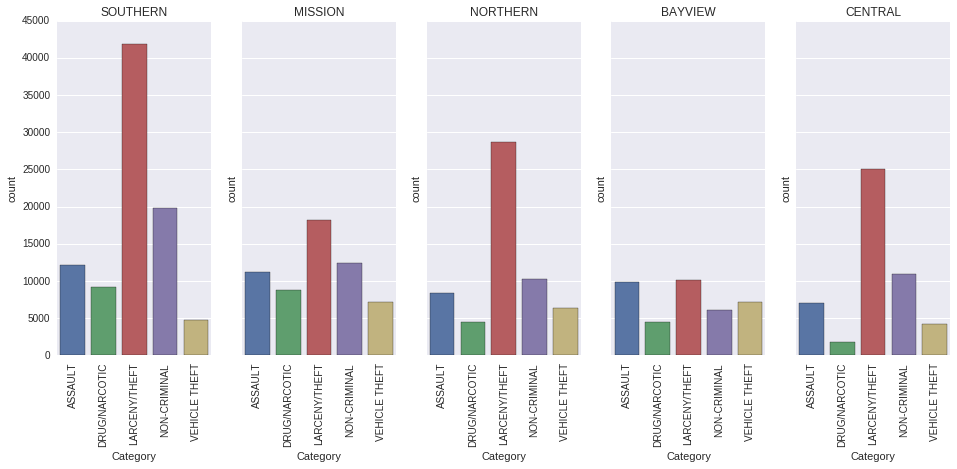

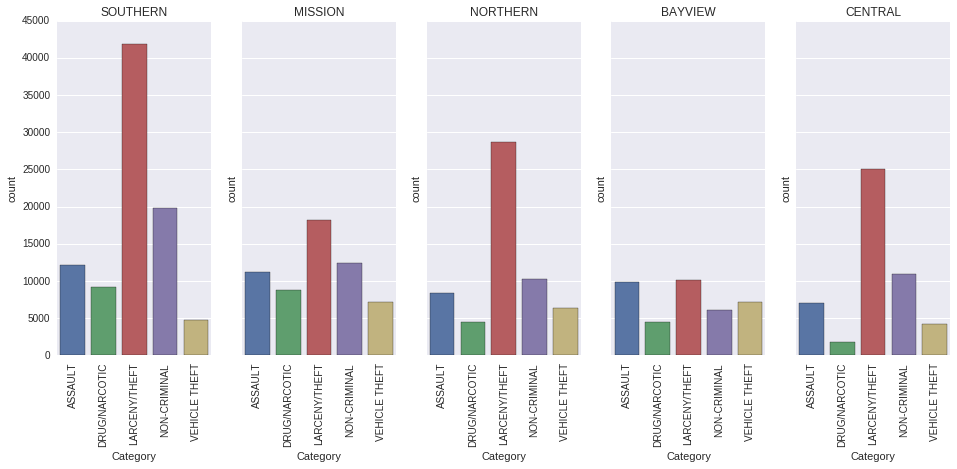

In [8]:
most_common_cats = train.Category[train.Category != "OTHER OFFENSES"].value_counts().index[0:5]
most_common_districts = train.PdDistrict.value_counts().index[0:5]


f, axtuple = plt.subplots(1, len(most_common_cats), sharey=True)

for i in range(len(most_common_districts)):
    
    subset = train[(train.PdDistrict == most_common_districts[i]) & train.Category.isin(most_common_cats)]
    
    ax = sns.countplot(x="Category", data=subset.sort_values("Category"), ax=axtuple[i])
    ax.set_title(most_common_districts[i])
    plt.sca(ax)
    plt.xticks(rotation=90)
    
plt.gcf().set_size_inches(16, 6, forward=True)


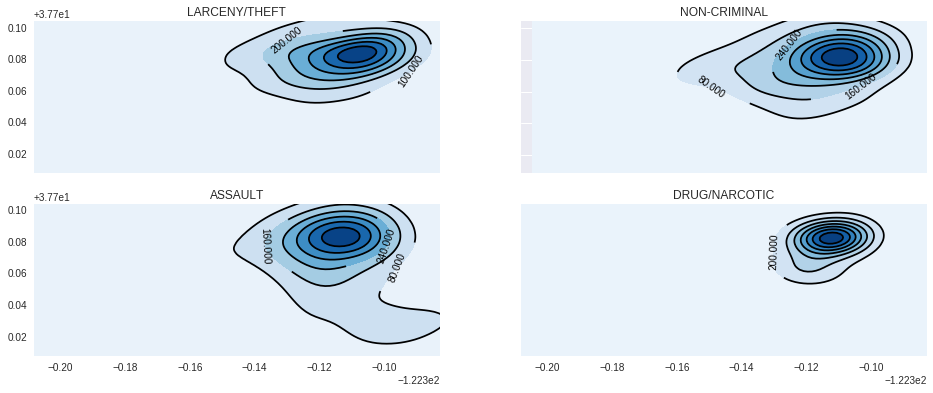

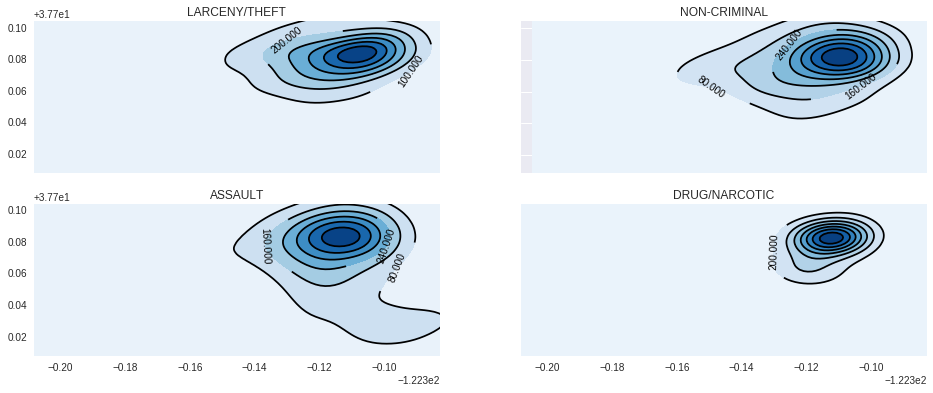

In [9]:
train_subset = get_random_subset(train, 5000)

cats = [['LARCENY/THEFT', 'NON-CRIMINAL'], ['ASSAULT', 'DRUG/NARCOTIC']]

f, axtuple = plt.subplots(2, 2, sharey=True, sharex=True)

rows, cols = axtuple.shape

for j in range(rows):
    
    for i in range(cols):

        subset = train_subset[train_subset.Category == cats[j][i]]

        x = subset.X
        y = subset.Y

        # plt.scatter(x, y)

        xmin, xmax = x.min(), x.max()
        ymin, ymax = y.min(), y.max()

        # # Peform the kernel density estimate
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        values = np.vstack([x, y])
        kernel = st.gaussian_kde(values)
        f = np.reshape(kernel(positions).T, xx.shape)

    #     fig = plt.figure()
        ax = axtuple[j, i]
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(cats[j][i])
        cfset = ax.contourf(xx, yy, f, cmap='Blues')
        cset = ax.contour(xx, yy, f, colors='k')
        ax.clabel(cset, inline=1, fontsize=10)
    

plt.gcf().set_size_inches(16, 6, forward=True)
    
# axtuple[0].set_ylabel("Frequency")
# plt.gcf().set_size_inches(16, 6, forward=True)

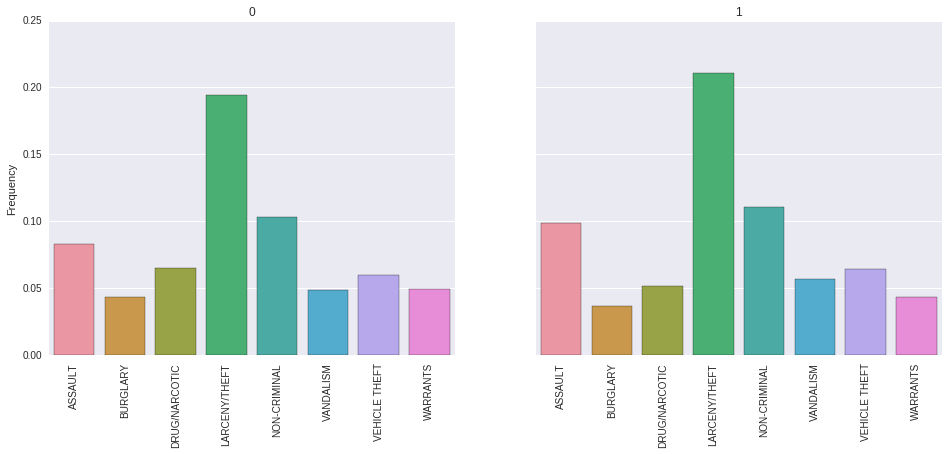

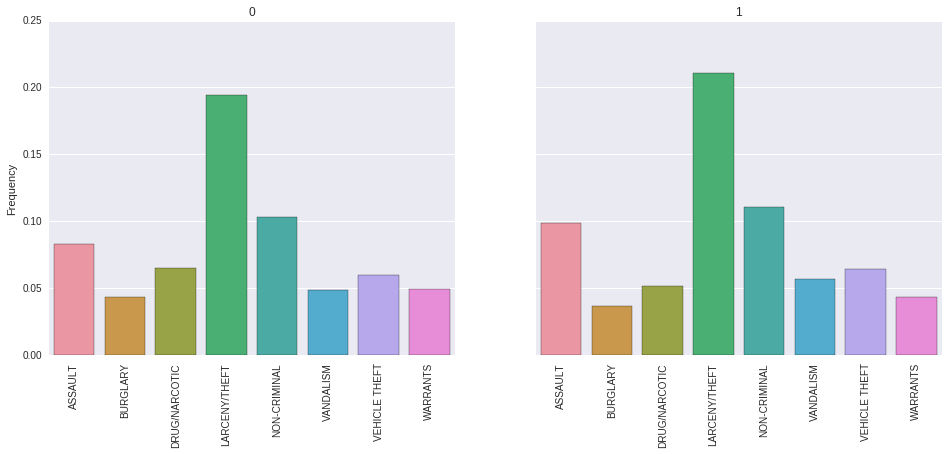

In [10]:
most_common_cats = train.Category[train.Category != "OTHER OFFENSES"].value_counts().index[0:8]
day_counts = train.DayOfWeek.value_counts().index[0:7]


train["Weekend"] = train["DayOfWeek"]
train.loc[train["Weekend"] == "Sunday", "Weekend"] = 1
train.loc[train["Weekend"] == "Saturday", "Weekend"] = 1
train.loc[train["Weekend"] == "Monday", "Weekend"] = 0
train.loc[train["Weekend"] == "Tuesday", "Weekend"] = 0
train.loc[train["Weekend"] == "Wednesday", "Weekend"] = 0
train.loc[train["Weekend"] == "Thursday", "Weekend"] = 0
train.loc[train["Weekend"] == "Friday", "Weekend"] = 0

day_type_counts = train.Weekend.value_counts().index[0:2]



f, axtuple = plt.subplots(1, len(day_type_counts), sharey=True)


for i in range(len(day_type_counts)):
    
    subset = train[train.Weekend == day_type_counts[i]]
    proportions = (subset.Category.value_counts().astype(float) / len(subset)).loc[most_common_cats]
    proportions = proportions.sort_index()
    
    
    
    ax = sns.barplot(x=proportions.index, y=proportions, ax=axtuple[i])
    ax.set_title(day_type_counts[i])
    ax.set_ylabel("")
    plt.sca(ax)
    plt.xticks(rotation=90)
    
axtuple[0].set_ylabel("Frequency")
plt.gcf().set_size_inches(16, 6, forward=True)


In [11]:

dow = {
    'Monday':0,
    'Tuesday':1,
    'Wednesday':2,
    'Thursday':3,
    'Friday':4,
    'Saturday':5,
    'Sunday':6
}
train['DOW'] = train.DayOfWeek.map(dow)

/home/brenna/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/brenna/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/brenna/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

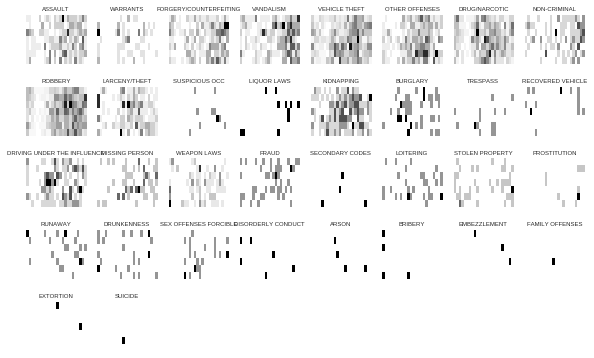

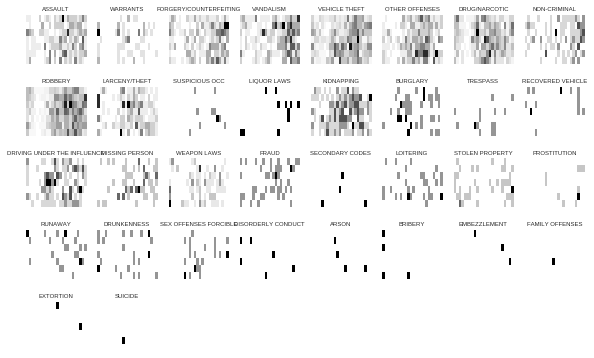

In [14]:
#FOUND ONLINE  https://www.kaggle.com/str8sky2star/sf-crime/studying-time-v-s-day-by-category/run/127456
#Could be interesting but not very clear visually
train_subset = get_random_subset(train, 5000)
train_subset['DOW'] = train_subset.DayOfWeek.map(dow)
train_subset['Hour'] = pd.to_datetime(train_subset.Dates).dt.hour
cats =pd.Series(train_subset.Category.values.ravel()).unique()
plt.figure(1,figsize=(10,6))
plt.subplots_adjust(hspace=0.5)
for i in np.arange(1,cats.size):
    ax = plt.subplot(5,8,i)
    ax.set_title(cats[i - 1],fontsize=6)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    plt.hist2d(
        train_subset[train_subset.Category==cats[i]].Hour.values,
        train_subset[train_subset.Category==cats[i]].DOW.values, 
        bins=[24,7],
        range=[[-0.5,23.5],[-0.5,6.5]]
    )
            

SyntaxError: invalid syntax (<ipython-input-19-76f2f00d98fc>, line 8)

SyntaxError: invalid syntax (<ipython-input-19-76f2f00d98fc>, line 8)

In [20]:
def plot_Category(df):
    cat_Count = df.groupby("Category").count()
    plt.figure()
    cat_Count.sort(columns="Dates",ascending=1)["Dates"].plot(kind="barh")
    plt.ticklabel_format(style='plain', axis='x', scilimits=(0,0))
    plt.tight_layout()
    plt.show()

/home/brenna/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
/home/brenna/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


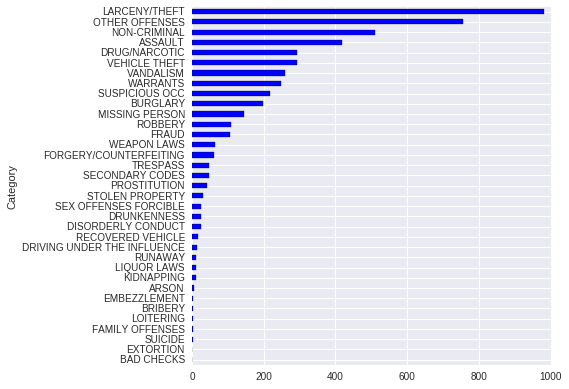

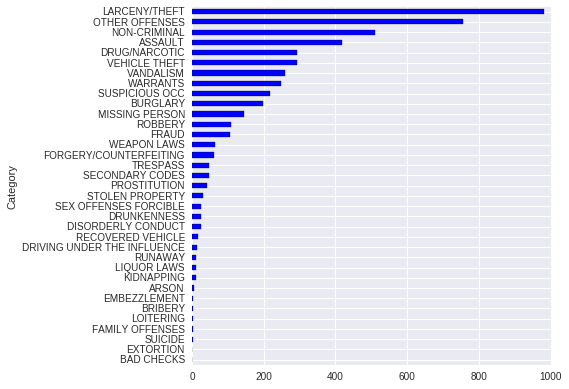

In [21]:
plot_Category(train_subset)

In [25]:
DOWCat = train_subset.groupby(['DOW', 'Category'])

print DOWCat

In [ ]:
train_subset[''].groupby(df['company']).describe()

X          Y  DOW  Hour
2 count    1.000000   1.000000    1     1
  mean  -122.439976  37.789921    1    10
  std           NaN        NaN  NaN   NaN
  min   -122.439976  37.789921    1    10
  25%   -122.439976  37.789921    1    10
  50%   -122.439976  37.789921    1    10
  75%   -122.439976  37.789921    1    10
  max   -122.439976  37.789921    1    10

X          Y  DOW  Hour
2 count    1.000000   1.000000    1     1
  mean  -122.439976  37.789921    1    10
  std           NaN        NaN  NaN   NaN
  min   -122.439976  37.789921    1    10
  25%   -122.439976  37.789921    1    10
  50%   -122.439976  37.789921    1    10
  75%   -122.439976  37.789921    1    10
  max   -122.439976  37.789921    1    10

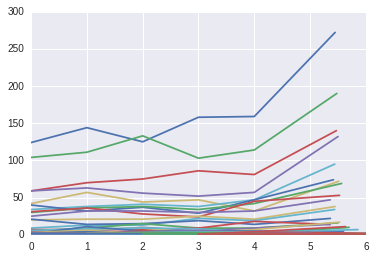

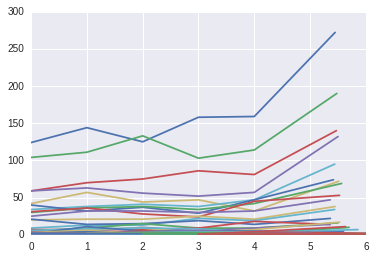

In [46]:
train_subset = train_subset.dropna(subset=['DOW', 'Category'])
categories = train_subset.Category.value_counts().index
bins = np.arange(0, 6, 1)
for c in categories:
    subset = train_subset[train_subset.Category == c]
    indices = np.digitize(subset.DOW, bins)
    groups = subset.groupby(indices)
    days = [g.DOW.mean() for _, g in groups]
    crimes = [len(g) for i, g in groups]
    plt.plot(days, crimes)

    
print groups
groups.describe()


In [47]:
train_subset = train_subset.dropna(subset=['DOW', 'Category'])
categories = train_subset.Category.value_counts().index
bins = np.arange(0, 6, 1)
for c in categories:
    subset = train_subset[train_subset.Category == c]
    indices = np.digitize(subset.DOW, bins)
    groups = subset.groupby(indices)
    days = [g.DOW.mean() for _, g in groups]
    crimes = [len(g) for i, g in groups]
    sns.swarmplot(x=day, y=crimes, hue="Category", data=train_subset);

AttributeError: 'module' object has no attribute 'swarmplot'

AttributeError: 'module' object has no attribute 'swarmplot'